In [0]:
import torch
import torchvision
from torchvision import datasets, transforms


In [0]:

trainset = torchvision.datasets.FashionMNIST(root='./data', 
                                      train=True,
                                      download=True, 
                                      transform=transforms.ToTensor())

testset = torchvision.datasets.FashionMNIST(root='./data', 
                                     train=False,
                                     download=True, 
                                     transform=transforms.ToTensor())

train = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

test = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
print(len(list(trainset)))





60000


In [0]:
for data in train:
    print(data[1])    # labels
    break

tensor([4, 0, 3, 4, 2, 4, 5, 4, 9, 2, 5, 2, 1, 2, 7, 6, 2, 8, 0, 7, 2, 0, 2, 3,
        1, 5, 4, 6, 4, 3, 8, 3])


In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [0]:
class MNIST(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 16, 5)
        self.conv2 = nn.Conv2d(16, 64, 5, padding=(2, 2))
        self.conv3 = nn.Conv2d(64, 256, 3, padding = (1, 1))
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = MNIST()

if torch.cuda.is_available:
    model.cuda()

In [0]:
X = torch.rand(2, 1, 28, 28)
X = X.cuda()
outputs = model(X)
print(outputs)
print(torch.argmax(outputs, 1))
print(len(outputs))

tensor([[ 0.0016,  0.0021,  0.0476,  0.0349,  0.0059, -0.0439, -0.0376, -0.0156,
          0.0037,  0.0256],
        [-0.0012,  0.0011,  0.0480,  0.0373,  0.0059, -0.0478, -0.0399, -0.0139,
          0.0066,  0.0217]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([2, 2], device='cuda:0', grad_fn=<NotImplemented>)
2


In [0]:
import torch.optim as optim

In [0]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [0]:
epochs = 10

for epoch in range(epochs):

    for i, (images, labels) in enumerate(train):
        if torch.cuda.is_available:
            X = images.cuda()
            y = labels.cuda()

        optimizer.zero_grad()

        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        if i%500 == 499:
            correct = 0
            total = 0
            print('epoch: {} -- iteration: {} -- loss: {}'.format(epoch+1, i+1, loss))
            for j, (images, labels) in enumerate(train):
                if torch.cuda.is_available:
                    X = images.cuda()
                    y = labels.cuda()
                outputs = model(X)
                predicted = torch.argmax(outputs.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum()
                accuracy = correct/total
            print('accuracy on the test set: {}'.format(100 * correct/total))

epoch: 1 -- iteration: 500 -- loss: 0.5362595319747925
accuracy on the test set: 73
epoch: 1 -- iteration: 1000 -- loss: 0.8186666369438171
accuracy on the test set: 77
epoch: 1 -- iteration: 1500 -- loss: 0.6198607087135315
accuracy on the test set: 79
epoch: 2 -- iteration: 500 -- loss: 0.3991733193397522
accuracy on the test set: 83
epoch: 2 -- iteration: 1000 -- loss: 0.33443328738212585
accuracy on the test set: 84
epoch: 2 -- iteration: 1500 -- loss: 0.38538992404937744
accuracy on the test set: 83
epoch: 3 -- iteration: 500 -- loss: 0.3340262472629547
accuracy on the test set: 86
epoch: 3 -- iteration: 1000 -- loss: 0.18047596514225006
accuracy on the test set: 85
epoch: 3 -- iteration: 1500 -- loss: 0.24253836274147034
accuracy on the test set: 86
epoch: 4 -- iteration: 500 -- loss: 0.6099706888198853
accuracy on the test set: 87
epoch: 4 -- iteration: 1000 -- loss: 0.5210540294647217
accuracy on the test set: 88
epoch: 4 -- iteration: 1500 -- loss: 0.27774569392204285
accuracy

In [0]:
print(loss)

tensor(0.1974, device='cuda:0', grad_fn=<NllLossBackward>)


In [0]:
correct = 0
total = 0
test_losses = []

with torch.no_grad():
    for j, data in enumerate(test):
        images, labels = data
        if (torch.cuda.is_available):
            X = images.cuda()
            y = labels.cuda()

        outputs = model(X)


        if j%20 == 0:
            test_loss = loss = criterion(outputs, y)
            test_losses.append(test_loss)

        predicted = torch.argmax(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum()
print('Accuracy of the network on the 10000 test images: %f %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 89.000000 %


In [0]:
import matplotlib.pyplot as plt

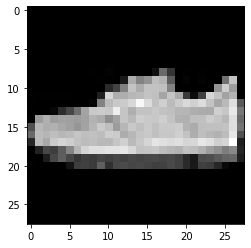

predicted : sneaker, ground truth : sneaker


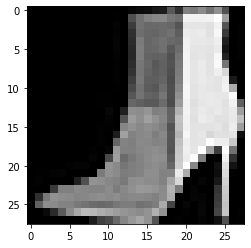

predicted : ankle boot, ground truth : ankle boot


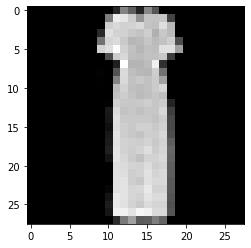

predicted : dress, ground truth : dress


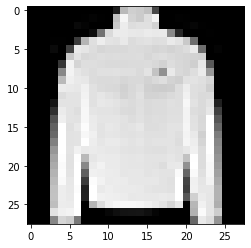

predicted : coat, ground truth : coat


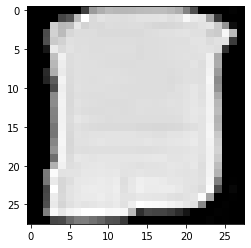

predicted : bag, ground truth : bag


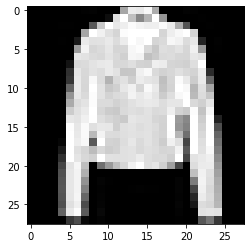

predicted : coat, ground truth : coat


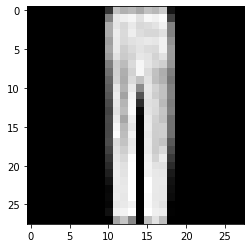

predicted : trouser, ground truth : trouser


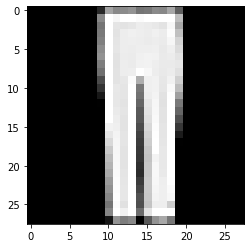

predicted : trouser, ground truth : trouser


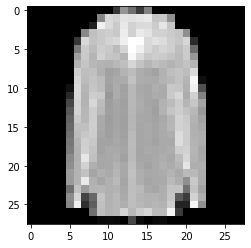

predicted : coat, ground truth : coat


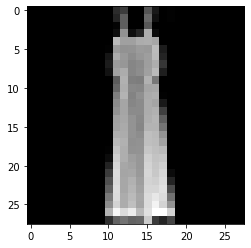

predicted : dress, ground truth : dress


In [0]:
classes = {0:'tshirt', 1:'trouser', 2:'pullover', 3:'dress', 4:'coat', 
           5:'sandal', 6:'shirt', 7:'sneaker', 8:'bag', 9:'ankle boot'}

for i in range(10): 
    show_img = images[i].view(28,28)
    plt.imshow(show_img, cmap = 'gray')
    plt.show()
    print('predicted : {}, ground truth : {}'.format(classes[int(predicted[i])],
                                                     classes[int(labels[i])]))